In [149]:
import numpy as np
from implementations import *
from preprocessing import z_score_outlier_detection
from IPython.core.interactiveshell import InteractiveShell
from utils import calculate_mse, split_data, standardize, calculate_mse_loss
from proj1_helpers import load_csv_data, predict_labels, create_csv_submission

# for visualisation purposes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from visualisation import corrdot

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
InteractiveShell.ast_node_interactivity = "last_expr"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0. Preprocess the data for the exploratory data analysis

In [119]:
TRAIN_PATH = "../data/train.csv"
TEST_PATH = "../data/test.csv"
VAL_PERCENTAGE = 0.4
Z_VALUE = 3.0
DO_Z_OUTLIER_DETECTION = False
Y, X, ids = load_csv_data(TRAIN_PATH)
Y_te, X_te, ids_te = load_csv_data(TEST_PATH)


In [120]:
# standarise 
X = standardize(X)
X_te = standardize(X_te)

In [36]:
# add bias term (column of ones)
X = np.hstack((np.ones((X.shape[0], 1)), X))
X_te = np.hstack((np.ones((X_te.shape[0], 1)), X_te))

# split data
(X_tr, Y_tr, ids_tr), (X_val, Y_val, ids_val) = split_data(X, Y, ids, val_prop=VAL_PERCENTAGE)

In [133]:
# find correlated features
cor_matrix = X_sub_df.corr().abs()

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),
                                      k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

# delete correlated features
X_uncorr = np.delete(X, to_drop, 1) 



## 1. Exploratory data analysis

In [148]:
# process data for plotting
# get N random samples for each feature samples
N = 100
X_sub = X_uncorr[np.random.permutation(X_uncorr.shape[0])][:N,:]
X_sub_df = pd.DataFrame(X_sub)

# split data for paired plots
split = int(X_sub_df.shape[1]/2)
X_sub_df_1 = X_sub_df.iloc[:100, :split]
X_sub_df_2 = X_sub_df.iloc[:100, split:]



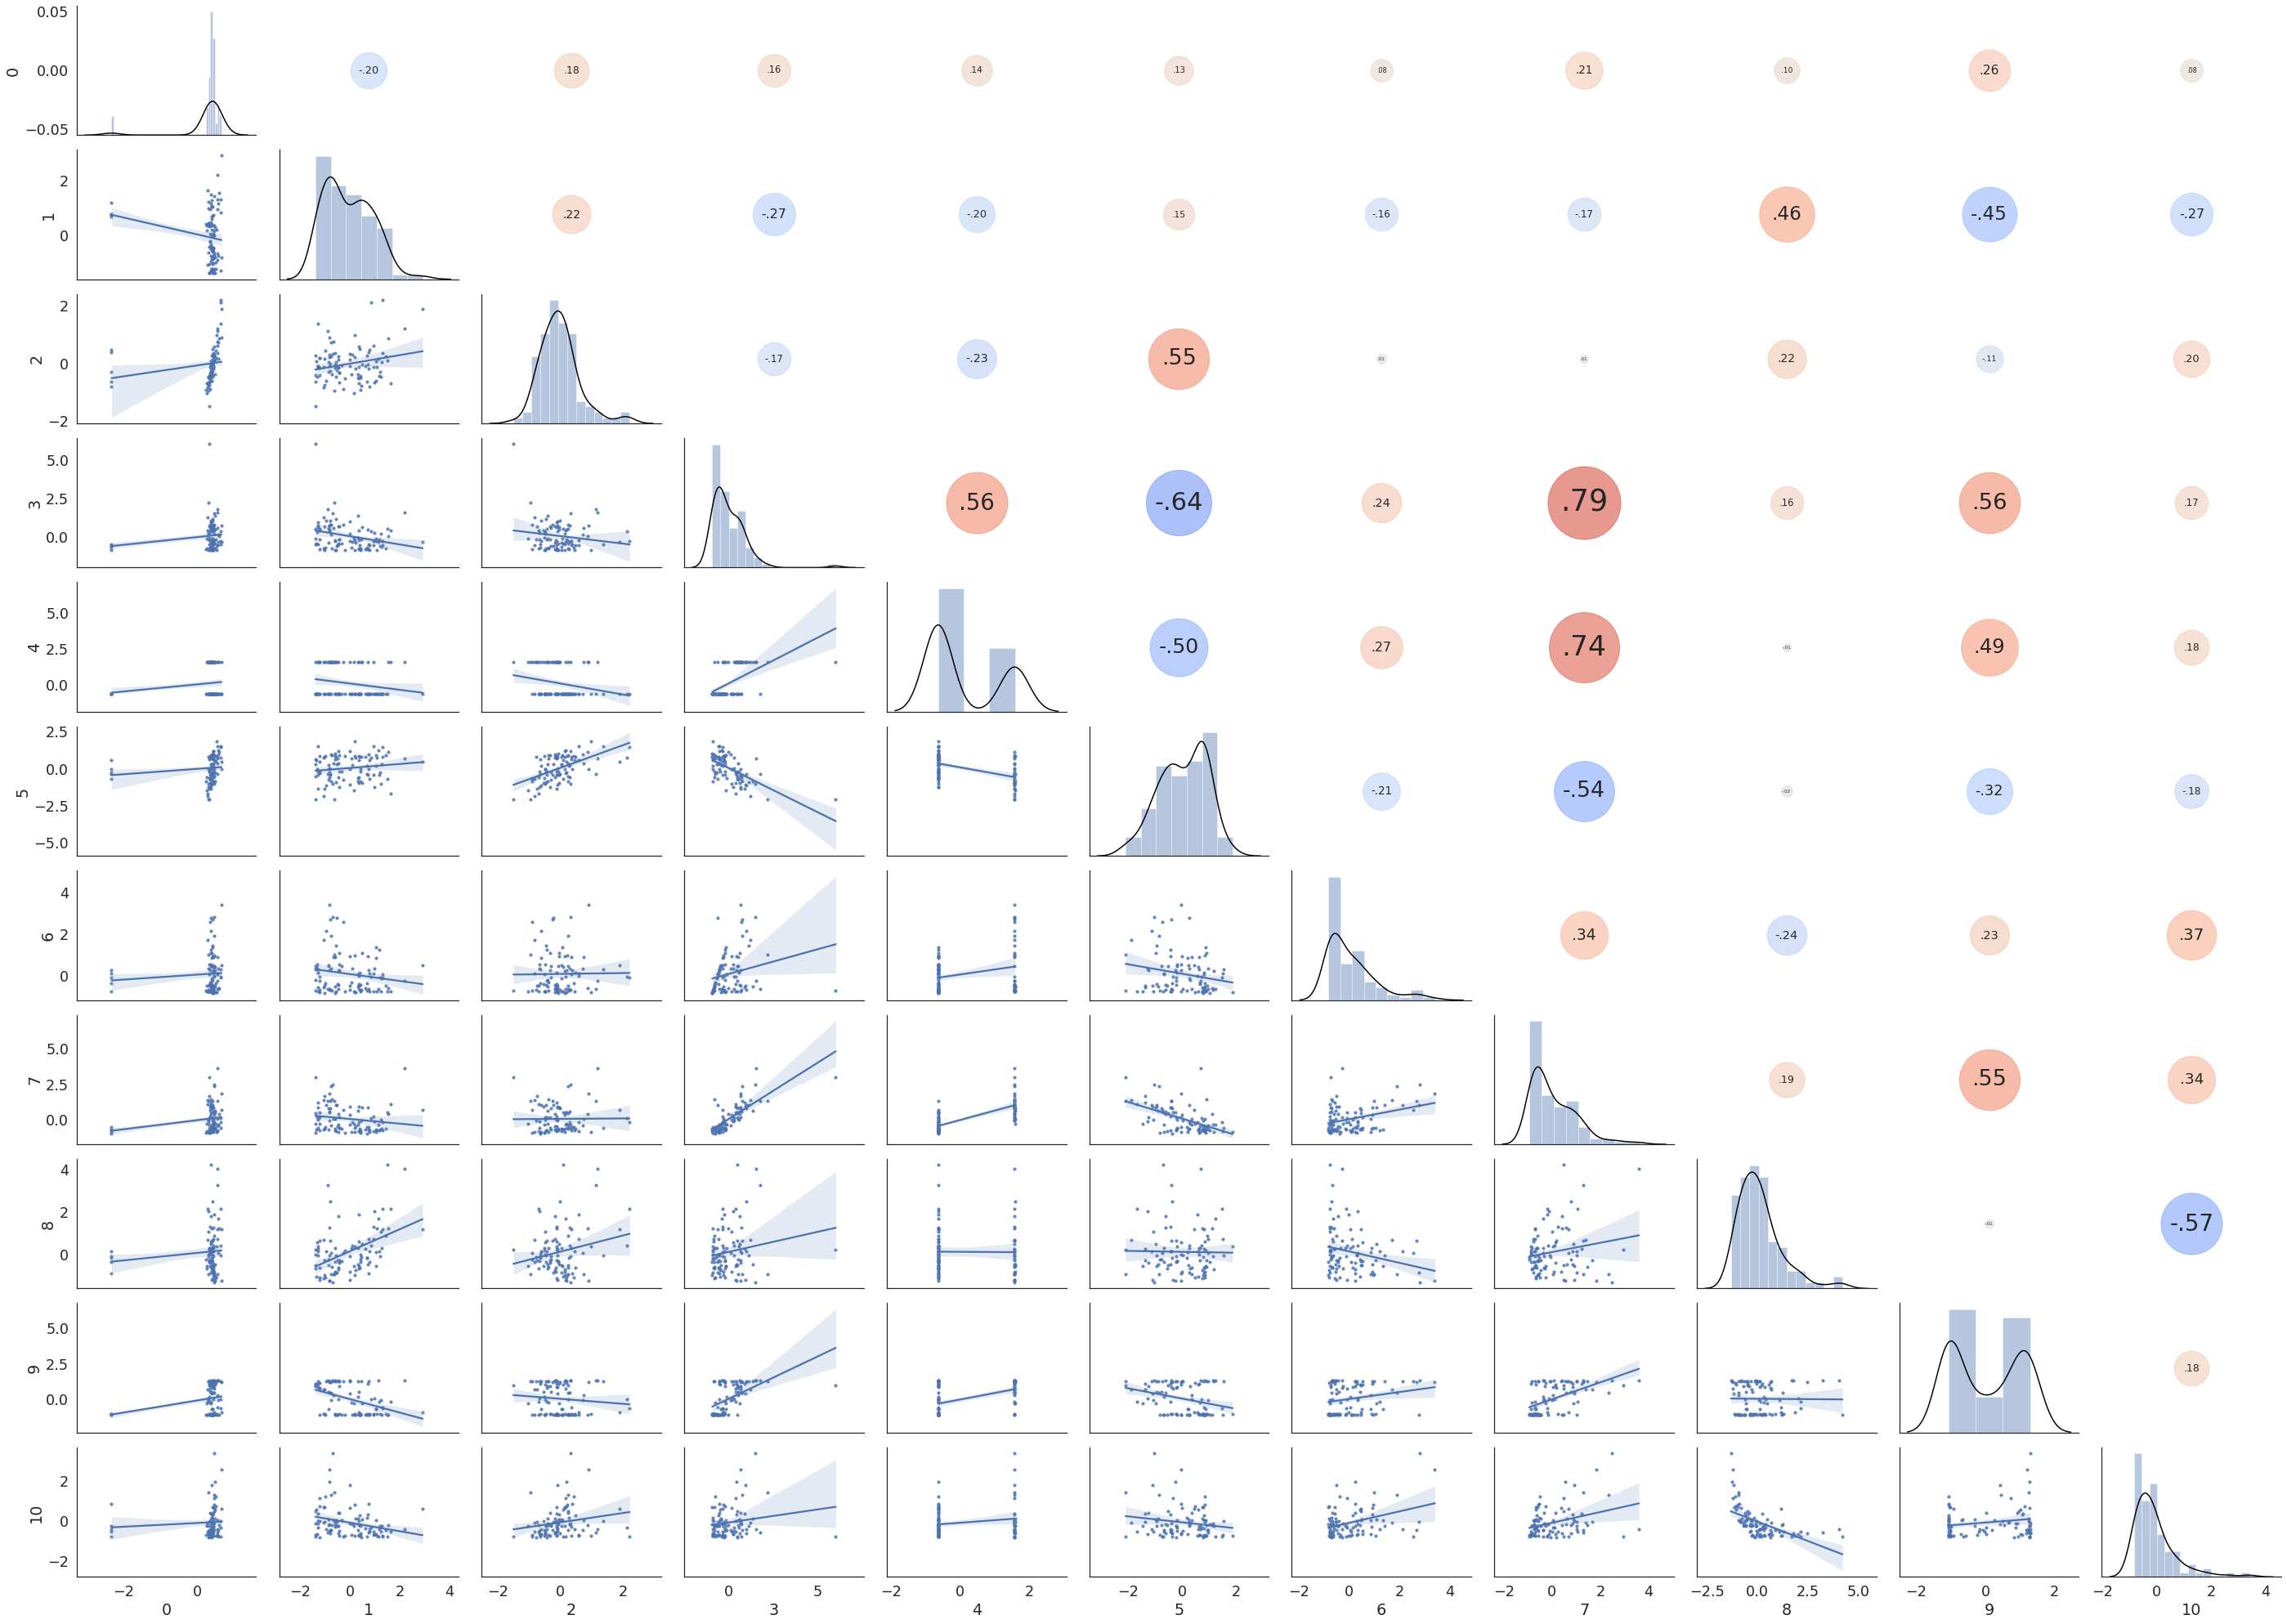

In [141]:
# paired plot of first half of features
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(X_sub_df_1, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, scatter_kws={'s':10})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot);

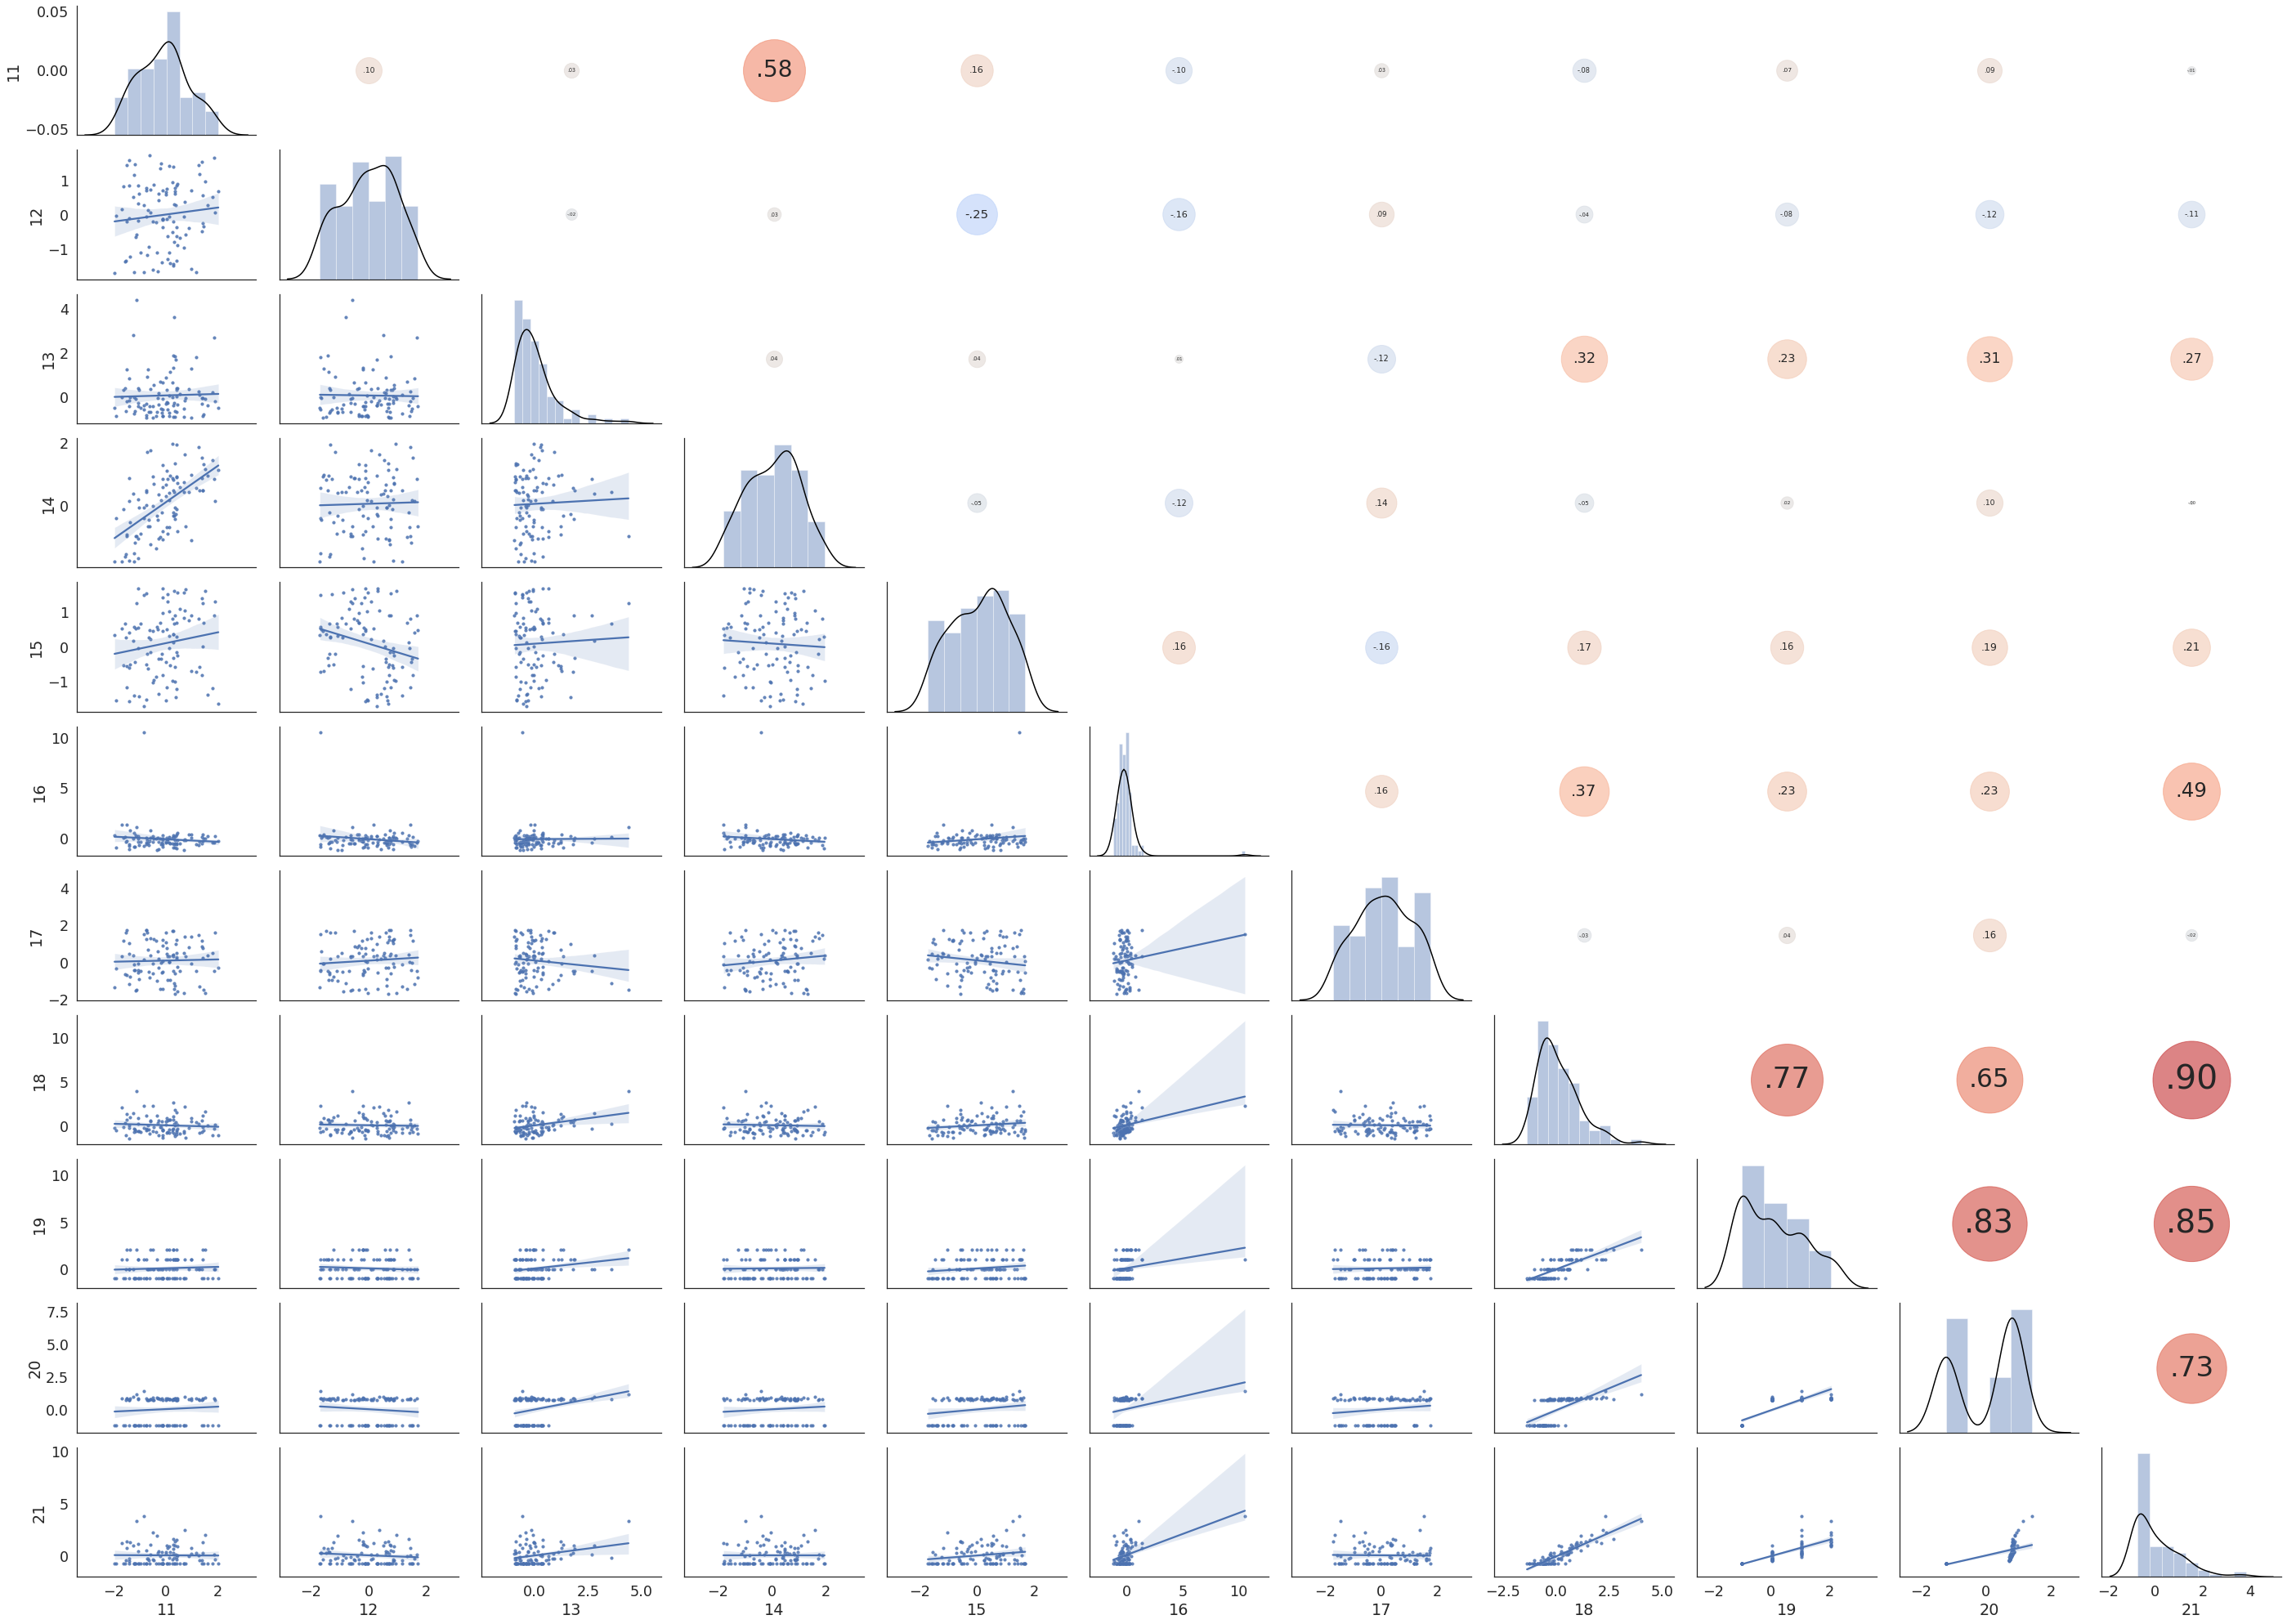

In [142]:
# paired plot of second half of features
g2 = sns.PairGrid(X_sub_df_2, aspect=1.4, diag_sharey=False)
g2.map_lower(sns.regplot, scatter_kws={'s':10})
g2.map_diag(sns.distplot, kde_kws={'color': 'black'})
g2.map_upper(corrdot);

## 2. Preprocessing

In [9]:
# Normalize dataset
for indx_col in range(tX.shape[1]):
    tX_st[:, indx_col] = (tX[:, indx_col] - np.mean(tX[:, indx_col])) / np.std(tX[:, indx_col])

# Split dataset
split_perc = 0.7
split_ind = int(len(y) * split_perc)

# Training set
y_train = y[:split_ind]
tX_train = tX[:split_ind]
ids_train = ids[:split_ind]

# Validation set
y_val = y[split_ind:]
tX_val = tX[split_ind:]
ids_val = ids[split_ind:]

## 3. Training

In [ ]:
# Set hyperparameters
max_iters = 100
gamma = 0.01
lambda_ = 0.1

# Initialize weights
initial_w = np.random.rand(D,)

from implementations import *
# Train
#weights_ls_GD, loss_ls_GD = least_squares_GD(y_train, tX_train, initial_w, max_iters, gamma)
#print(loss_ls_GD)
#weights_ls_SGD, loss_ls_SGD = least_squares_SGD(y_train, tX_train, initial_w, max_iters, gamma)
#weights_ls, loss_ls = least_squares(y_train, tX_train)
# weights_rr, loss_rr = ridge_regression(y_train, tX_train, lambda_)
# weights_lr, loss_lr = logistic_regression(y_train, tX_train, initial_w, max_iters, gamma)
# weights_reg_lr, loss_reg_lr = reg_logistic_regression(y_train, tX_train, lambda_, initial_w, max_iters, gamma)

## 4. Evaluation

In [ ]:
from utils import cross_validation, build_k_indices
# Cross-validation

k = 5
k_indices = build_k_indices(y, k)
ls_GD_losses = []
ls_losses = []

for k_iteration in range(k):
    tX_train, y_train, tX_val, y_val = cross_validation(y, tX, k_indices, k_iteration)
    weights_ls_GD, loss_ls_GD = least_squares_GD(y_train, tX_train, initial_w, max_iters, gamma)
    weights_ls, loss_ls = least_squares(y_train, tX_train)

    y_pred_ls_GD_val = tX_val @ weights_ls_GD
    y_pred_ls_val = tX_val @ weights_ls

    ls_GD_losses.append(calculate_mse_loss(y_val, y_pred_ls_val))
    ls_losses.append(calculate_mse_loss(y_val, y_pred_ls_val))

ls_GD_losses = np.array(ls_GD_losses)
ls_losses = np.array(ls_losses)

ls_GD_mean_loss = np.mean(ls_GD_losses)
ls_mean_loss = np.mean(ls_losses)

print(ls_GD_mean_loss, ls_mean_loss)

## Generate predictions and save output in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
# TODO: decide real weights
weights = least_squares_GD(y, tX, initial_w, max_iters, gamma)
OUTPUT_PATH = '../data/submission.csv'
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)